# Estimation and Validation of a Markov State Model

## Estimation of a Markov State Model
Now that we have covered the theoretical background of Markov state modeling, let us dive into how to generate a Markov model using `msmhelper`. The package provides two approaches for creating a Markov model: a method-based approach and an object-oriented approach via the [`StateTraj`](../../reference/#msmhelper.StateTraj) class.

Let's start by importing the module and create a toy state trajectory. If you want to follow along this tutorial directly with your data, feel free to load your data, e.g. with `traj = np.loadtxt(filename)`. It should be noted that, the lag time is here chosen arbitrarly. In the second section, we will discuss on how to choose an appropriate lag time.

In [97]:
import msmhelper as mh
from msmhelper.utils import datasets

lagtime = 1  # given in units of timesteps

# to mimic real MD data, here we use a non-Markovian trajectory
_, traj = datasets.hummer15_8state(0.2, 0.1, int(1e6), return_macrotraj=True)

### Method-Based Approach
Let's start with the estimation of a Markov model using the method approach. With the method [`mh.estimate_markov_model`](../../reference/msm/#msmhelper.msm.msm.estimate_markov_model), the estimation of a Markov model can be achieved.

In [98]:
tmat, states = mh.msm.estimate_markov_model(traj, lagtime)
print(f'T_ij = \n{tmat}\nstates = {states}')

T_ij = 
[[0.95041873 0.04958127 0.         0.        ]
 [0.04925727 0.90056683 0.0501759  0.        ]
 [0.         0.04974171 0.89988428 0.05037402]
 [0.         0.         0.05034519 0.94965481]]
states = [1 2 3 4]


### Object-Oriented Approach via `StateTraj`
Alternatively, the object-oriented approach involves creating an instance of the StateTraj class and calling its methods to estimate the Markov state model.

In [99]:
straj = mh.StateTraj(traj)
tmat, states = straj.estimate_markov_model(lagtime)
print(f'T_ij = \n{tmat}\nstates = {states}')

T_ij = 
[[0.95041873 0.04958127 0.         0.        ]
 [0.04925727 0.90056683 0.0501759  0.        ]
 [0.         0.04974171 0.89988428 0.05037402]
 [0.         0.         0.05034519 0.94965481]]
states = [1 2 3 4]


At first glance, creating an instance of the `StateTraj` class may seem like an unnecessary additional step, but it offers several advantages. First, when estimating the Markov model multiple times, the object-oriented approach has a [major performance boost](../../benchmark) by converting the trajectory to the StateTraj format once before. Second, using the Hummer-Szabo projection requires the use of the object-oriented approach, specifically the `LumpedStateTraj` class.

Once the Markov model is estimated, it's important to validate it to ensure that it accurately represents the system being studied. In the following section, we will cover the validation of a Markov model using `msmhelper`.

## Validation of a Markov State Model

Once we have estimated a Markov state model, it is important to validate it to ensure that it accurately represents the system being studied. Two commonly used validation techniques are the implied timescales and Chapman-Kolmogorov tests.

In the following, we will show how to use the implied timescales and Chapman-Kolmogorov tests to validate a Markov state model using `msmhelper`.

### Implied Timescales

Implied timescales are a measure of the time scales of the Markov state model. They can be used to assess the convergence of the Markov state model, if the model converged the time scales is constant. They are defined by
$$t_i = - \frac{t_\text{lag}}{\log(\lambda_i)}$$
where $\lambda_i$ is the $i$-th eigenvalue.

Estimating the implied timescales is straight forward and can be achieved via

In [100]:
lagtimes = np.arange(1, 15)
impl_times = mh.msm.implied_timescales(traj, lagtimes, ntimescales=3)

To visualize the results we will use matplotlib.

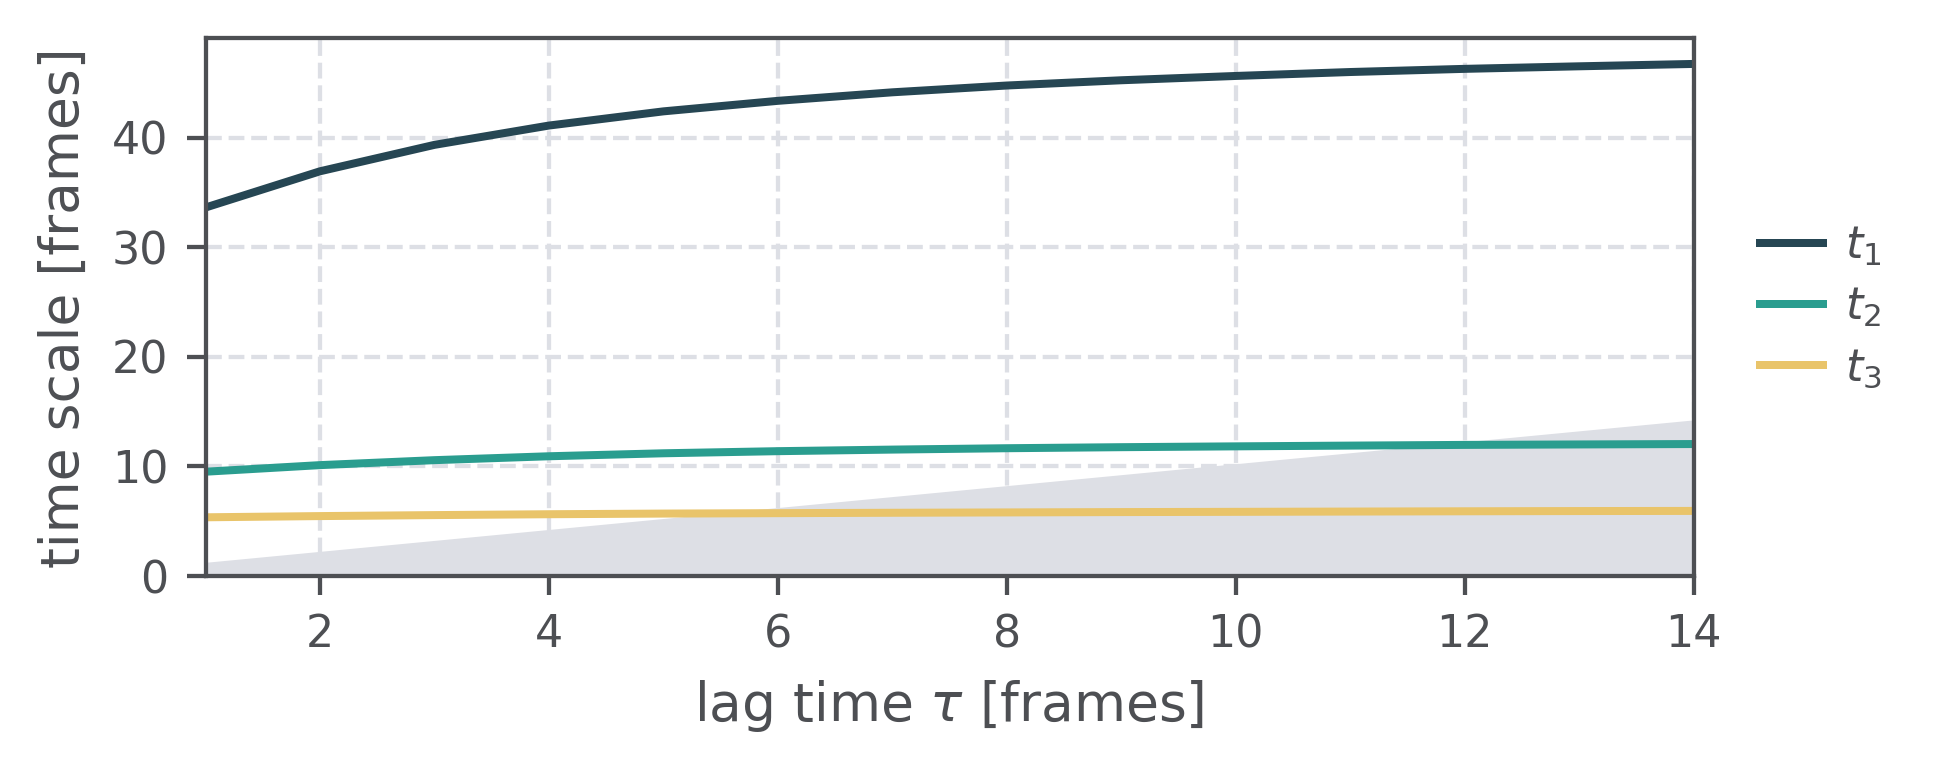

In [101]:
import prettypyplot as pplt
from matplotlib import pyplot as plt

pplt.use_style(figsize=(5, 2), colors='pastel_autunm', latex=False)

def plot_impl_times(impl_times):
    """Plot the implied timescales"""
    _, ax = plt.subplots()
    for idx, impl_time in enumerate(impl_times.T):
        ax.plot(lagtimes, impl_time, label=f'$t_{idx + 1}$')

    ax.set_xlim(lagtimes[0], lagtimes[-1])
    # highlight diagonal
    ax.fill_between(ax.get_xlim(), ax.get_xlim(), color='pplt:grid')
    ax.set_ylim(0, impl_times.max() * 1.05)
    ax.set_xlabel(r'lag time $\tau$ [frames]')
    ax.set_ylabel('time scale [frames]')
    pplt.legend(outside='right', frameon=False)

plot_impl_times(impl_times)

We find that the the third time scale $t_3$ is constant for all lag times. The second time scale converges around $\tau\approx 5$ and the slowest timescales $t_1$ at around $\tau\approx 10$.

### Chapman-Kolmogorov Test

The Chapman-Kolmogorov (CK) test, on the other hand, is a statistical test that measures how well the Markov state model reproduces the dynamics of the original system. The test involves propagating the Markov state model for a given amount of timesteps and comparing the distribution of states obtained from the simulation to the distribution of states obtained from the original trajectory, so if
$$T(\tau n) = T^n(\tau)$$
holds.

Estimating the CK test we need to specify for which lag times we want to validate the model. This is straight forward and can be achieved via

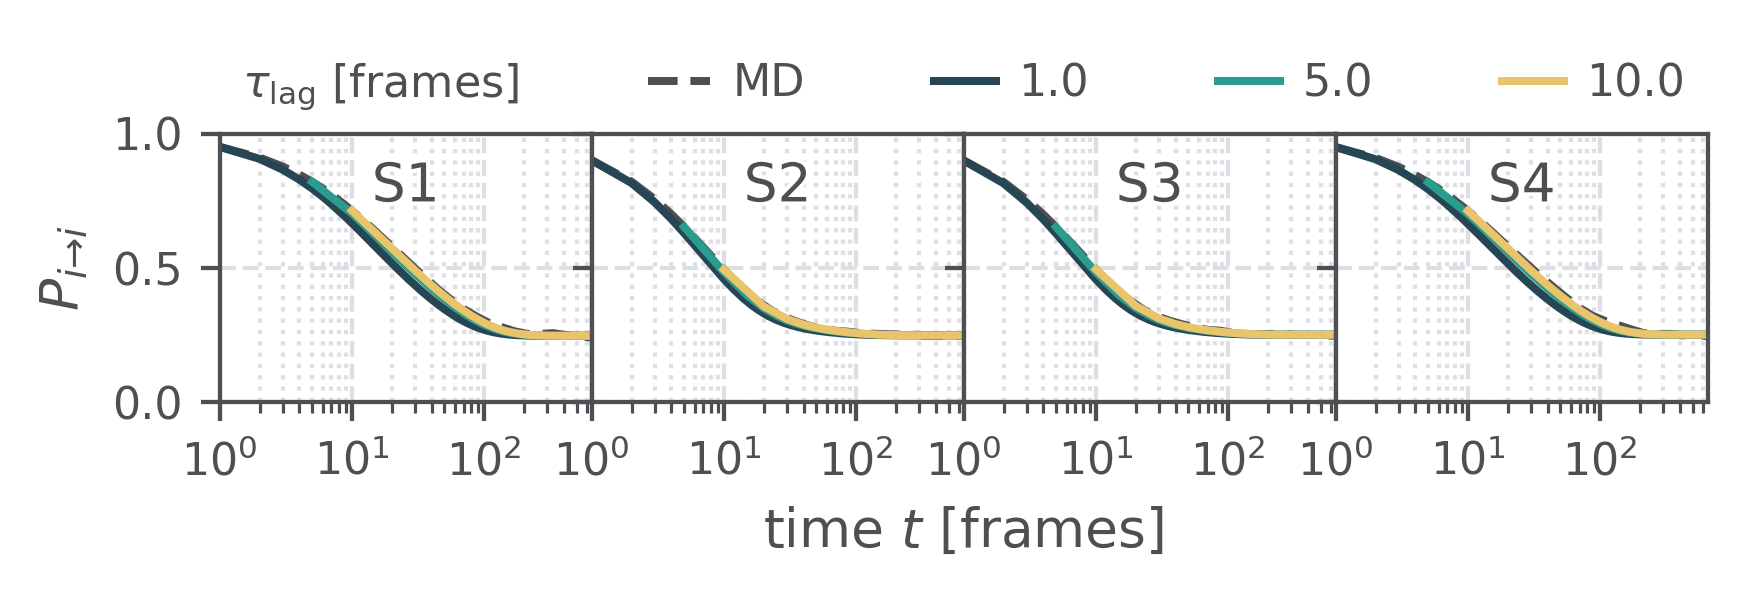

In [107]:
# change figsize
pplt.update_style(figsize=(5, 1))

lagtimes = [1, 5, 10]
tmax = 650

# estimating the CK test
ck = mh.msm.ck_test(traj, lagtimes, tmax)

# plot the results
_ = mh.plot.plot_ck_test(ck=ck, grid=(1, 4))

In this simple 4 state model, we see directly the connection between both approaches. The slowest time scale $t_1\approx 45$ describes the escape time of the first and last state (S1/S4). The non-convergence of time scale $t_1$ at $\tau=5$ results directly to the offset between the black curve (MD) and the model prediction for state S1 and S4.